In [2]:
#@markdown ##import core
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [54]:
#@markdown ##import colab
from google.colab import drive

## google drive
drive.mount('/gdrive', force_remount=True)
data = pd.read_csv( '/gdrive/MyDrive/1 UNI/BIO/210422_red_npc/cell1_tr1000_def500.csv',
                   header = None, names=["x", "y", "z", "n", "bg","fit","id","frame"])
drift = pd.read_csv('/gdrive/MyDrive/1 UNI/BIO/210422_red_npc/day2_cell1_driftValues.csv')

Mounted at /gdrive


In [4]:
#@markdown ##import jupyter
#%matplotlib ipympl
#%matplotlib widget
#%matplotlib interactive
#%matplotlib inline
import trackpy
#import sdt
#from sdt import io, chromatic, multicolor, brightness

## local
data = pd.read_csv( 'data/210422_npc/cell2_tr800_def500.csv',
                   header = None, names=["x", "y", "z", "n", "bg","fit","id","frame"])
drift = pd.read_csv('data/210422_npc/cell2_driftValues.csv')

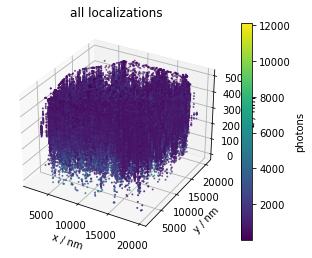

In [5]:
#@markdown ## plot raw data
#@markdown > import **colab** or **jupyter** first.

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
f = ax.scatter(data['x'], data['y'], data['z'], s=1 ,c=data['n'])
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title('all localizations')
cbar = plt.colorbar( f, label = 'photons' )
plt.show()

In [7]:
#@markdown ## import & scale drift
#@markdown > set **magnification** via factor in drift.

drift['Y2']=drift['Y2']*146.6
drift['Y3']=drift['Y3']*146.6
drift['X2']=np.round(drift['X2'])
drift['X3']=np.round(drift['X3'])

drift

,X0,Y0,Y1,X2,Y2,X3,Y3
0,2205.5,0.000000,0.000000,1.0,1502.410485,1.0,563.078872
1,7524.0,-0.135277,-0.060043,251.0,1332.025397,251.0,499.227447
2,15006.0,-0.105056,-0.117081,501.0,1161.640310,501.0,435.376022
3,25566.0,-0.022300,-0.143226,751.0,991.276713,751.0,371.524598
4,40879.0,-0.030004,-0.130091,1001.0,820.891626,1001.0,307.651681
...,...,...,...,...,...,...,...
195,NaN,NaN,NaN,48750.0,-1095.553763,48750.0,-2540.431341
196,NaN,NaN,NaN,49000.0,-1109.867142,49000.0,-2532.329023
197,NaN,NaN,NaN,49250.0,-1124.180520,49250.0,-2524.205214
198,NaN,NaN,NaN,49500.0,-1138.493899,49500.0,-2516.102895


In [8]:
#@markdown ## apply drift correction

for i in range(len(drift)-1):
    fr=data[(data['frame']>=drift['X2'].iloc[i]) & (data['frame']<drift['X2'].iloc[i+1])]
    fr['y']=fr['y']-drift['Y2'].iloc[i]
    fr['x']=fr['x']-drift['Y3'].iloc[i]
    data[(data['frame']>=drift['X2'].iloc[i]) & (data['frame']<drift['X2'].iloc[i+1])]=fr                                                             

<ipython-input-8-f787c9738b52>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr['y']=fr['y']-drift['Y2'].iloc[i]
<ipython-input-8-f787c9738b52>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr['x']=fr['x']-drift['Y3'].iloc[i]
<ipython-input-8-f787c9738b52>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

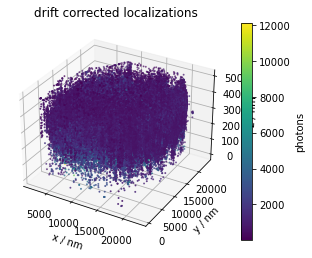

In [9]:
#@markdown ## plot drift corrected data

fig=plt.figure()
ax = fig.add_subplot( projection = '3d' )
f=ax.scatter( data['x'], data['y'], data['z'], s=1 ,c=data['n'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title('drift corrected localizations')
cbar=plt.colorbar( f, label = 'photons' )

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

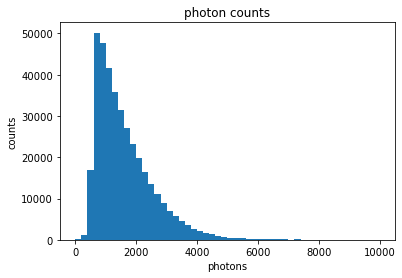

In [10]:
#@markdown ## histogram
#@markdown > set `max_photons` accordingly (default 10000).
max_photons = 10000 #@param {type:"slider", min:0, max:40000, step:1000}

fig = plt.figure()
plt.hist( data['n'], bins=50, range=( 0, max_photons ) )
plt.title('photon counts')
plt.xlabel('photons')
plt.ylabel('counts')
plt.tight_layout

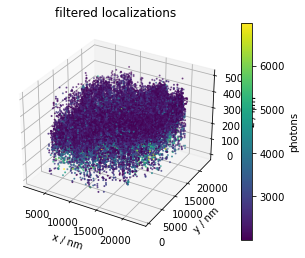

In [11]:
#@markdown ## filter
#@markdown > set `min_photons` and `max_photons` accordingly (default 2000 < photons < 7000).\
#@markdown > set `min_z` and `max_z` accordingly (default 0 < z < 499).\
#@markdown > set `min_fit` accordingly (default 6e6).
min_photons = 2000 #@param {type:"slider", min:0, max:40000, step:1000}
max_photons = 7000 #@param {type:"slider", min:0, max:40000, step:1000}
min_z = 0 #@param {type:"slider", min:0, max:500, step:1}
max_z = 499 #@param {type:"slider", min:0, max:500, step:1}
min_fit = 6e6 #@param {type:"slider", min:0, max:1e7, step:1000}

fdata = data[ ( data['n'] > min_photons ) &
             ( data['n'] < max_photons ) & 
             ( data['z'] > min_z ) &
             ( data['z'] < max_z ) &
             ( data['fit'] < min_fit ) ]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( fdata['x'], fdata['y'], fdata['z'], s=1 ,c=fdata['n'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title('filtered localizations' )
cbar = plt.colorbar( ff, label = 'photons' )

In [ ]:
#@markdown ## track all in x,y
#@markdown > set `sr` to wanted search range (default 50).\
#@markdown > set `mem` to wanted memory (default 10).
sr = 50 #@param {type:"slider", min:0, max:100, step:1}
mem = 10 #@param {type:"slider", min:0, max:100, step:1}

linkedxy = trackpy.link_df( fdata, pos_columns = ["x","y","z"], search_range = sr,  memory = mem )

particles = linkedxy.groupby( "particle" ).aggregate( np.mean )
std_pos = linkedxy.groupby( "particle" ).aggregate( 'std' )
particles["length"] = linkedxy.groupby( "particle" ).apply( len )
particles["z_std"] = std_pos['z'].copy()
particles["x_std"] = std_pos['x'].copy()
particles["y_std"] = std_pos['y'].copy()

particles

Frame 1980: 3 trajectories present.


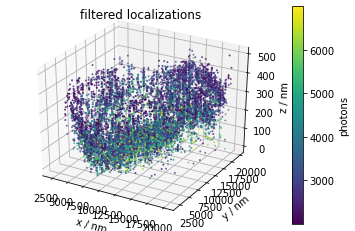

In [63]:
#@markdown ## cut down to tracked particles
#@markdown > set `localisations = particles` if tracking.\
#@markdown > set `localisations = fdata.iloc[0:10000,0:4]` otherwise to select first 10000 rows.
tracking = True #@param {type:"boolean"}
if tracking:
  localisations = particles
else:
  localisations = fdata.iloc[0:10000,0:4]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( localisations['x'], localisations['y'], localisations['z'], s=1 ,c=localisations['n'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title('filtered localizations')
cbar = plt.colorbar( ff, label = 'photons' )
plt.show()

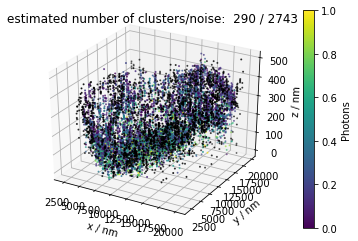

In [64]:
#@markdown ## compute dbscan
#@markdown > set `dim = 2` for clustering in x and y (default).\
#@markdown > set `dim = 3` for experimental clustering in 3d; be aware that x,z and y precision probably vary!\
#@markdown > set `eps` (default 200).\
#@markdown > set `min_samples` (default 10).\
dim = "2" #@param [2, 3]
eps = 200 #@param {type:"slider", min:0, max:500, step:10}
min_samples = 10 #@param {type:"slider", min:1, max:100, step:1}

alocalisations = localisations.to_numpy()
alocalisations[ :, 0:2 ]

db = DBSCAN( eps, min_samples ).fit( alocalisations[ :, 0:int( dim ) ] ) # cluster 2d
core_samples_mask = np.zeros_like( db.labels_, dtype=bool )
core_samples_mask[ db.core_sample_indices_ ] = True
labels = db.labels_
localisations[ "cluster" ] = labels

# count clusters (ignore noise if present)
n_clusters_ = len( set( labels ) ) - ( 1 if -1 in labels else 0 )
n_noise_ = list( labels ).count( -1 )

#print('Estimated number of clusters: %d' % n_clusters_)
#print('Estimated number of noise points: %d' % n_noise_)

nlocalisations = localisations.loc[ localisations['cluster'] == -1 ]
clocalisations = localisations.loc[ localisations['cluster'] != -1 ]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( clocalisations['x'], clocalisations['y'], clocalisations['z'], s=1 ,c=clocalisations['n'] )
ff = ax.scatter( nlocalisations['x'], nlocalisations['y'], nlocalisations['z'], s=1 ,c="black" )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title('{0} {1} {2} {3}'.format( 'estimated number of clusters/noise: ', n_clusters_, '/', n_noise_ ) )
cbar = plt.colorbar( ff, label = 'Photons' )
plt.show()

In [65]:
#@markdown ## analyse clusters

clabels = set(labels)
cnames = [ "counts", "xmean", "ymean", "zmean", "nmean", "xvar", "yvar", "zvar", "nvar", "label" ]
clusters = pd.DataFrame( index = clabels, columns = cnames, dtype="float64" )
clusters[ "label" ] = clabels

for k in clabels:
  tmp = localisations.loc[ localisations['cluster'] == k ]
  clusters.loc[ k, "counts" ] = len( tmp )
  for label in [ "x", "y", "z", "n" ]:
    clusters.loc[ k, label+"mean"  ] = np.mean( tmp.loc[ :, label ] )
    clusters.loc[ k, label+"var"  ] = np.var( tmp.loc[ :, label ] )

print( * [ 'analysed clusters: ', len( clusters ) ] )


analysed clusters:  291


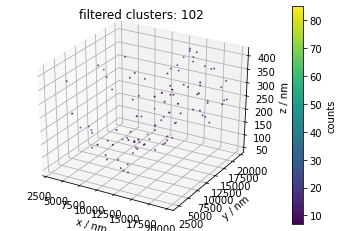

In [66]:
#@markdown ## filter clusters based on variance
#@markdown > set `xythresh` to wanted x,y variance (default 1e4)\
#@markdown > set `zthresh` to wanted z variance (default 1e4)
xythresh = 10000 #@param {type:"slider", min:0, max:1e5, step:1e3}
zthresh = 10000 #@param {type:"slider", min:0, max:1e5, step:1e3}

fclusters = clusters[ ( clusters['xvar'] < xythresh ) & 
                     ( clusters['yvar'] < xythresh ) &
                     ( clusters['zvar'] < zthresh) ]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( fclusters['xmean'], fclusters['ymean'], fclusters['zmean'], s=1 ,c=fclusters['counts'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( 'filtered clusters: ' + str( len( fclusters ) ) )
cbar = plt.colorbar( ff, label='counts' ) 

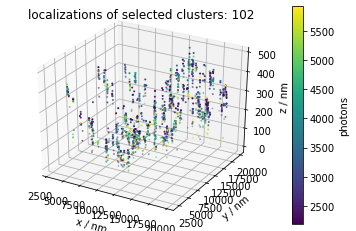

In [74]:
#@markdown ## select best clusters & plot localisations
#@markdown > set `show_clusters` to wanted number of best clusters (default 100).
show_clusters = 700 #@param {type:"slider", min:0, max:1000, step:100}
show_clusters = min( show_clusters, len( sclusters ) )

## sort by variance
#sclusters = fclusters.sort_values( "xvar" )

## sort by x and y variance using least squares
sclusters = fclusters.loc[ ( fclusters.xvar ** 2 + fclusters.yvar ** 2 ).sort_values().index ]
selected_clusters = sclusters["label"].iloc[ 0:show_clusters ]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
for clus in selected_clusters:
  flocalisations = localisations[ ( localisations['cluster'] == clus ) ]
  ff = ax.scatter( flocalisations['x'], flocalisations['y'], flocalisations['z'], s=1 ,c = flocalisations['n'] )

ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( "localizations of selected clusters: " + str( len( selected_clusters ) ) )
cbar = plt.colorbar( ff, label = 'photons' )

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


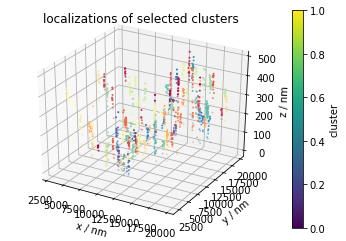

In [18]:
#@markdown ## plot localisations as colored clusters

sclusters['color'] = ""
vec = np.linspace( 0, 1, len( selected_clusters ) )
for each in range( len( selected_clusters ) ):
  sclusters['color'].iloc[ each ] = plt.cm.Spectral( vec[ each ] )

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
for clus in selected_clusters:
  flocalisations = localisations[ ( localisations['cluster'] == clus ) ]
  #print( tuple(  sclusters.loc[clus, "color" ] ) )
  ff = ax.scatter( flocalisations['x'], flocalisations['y'], flocalisations['z'],
                  s=1 ,color = tuple(  sclusters.loc[ clus, "color" ] ) )

ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( "localizations of selected clusters" )
cbar = plt.colorbar( ff, label = 'cluster' )

In [ ]:
#@markdown ## optional: filter one cluster based on mean location and size

cluster = 3 # select cluster
size = 300 # select cluster size

flocalisations = localisations[ ( localisations['x'] > fclusters.loc[ :, "xmean" ].iloc[ cluster ] - size ) &
                               ( localisations['x'] < fclusters.loc[ :, "xmean" ].iloc[ cluster ] + size ) &
                               ( localisations['y'] > fclusters.loc[ :, "ymean" ].iloc[ cluster ] - size ) &
                               ( localisations['y'] < fclusters.loc[ :, "ymean" ].iloc[ cluster ] + size )
                               #( localisations['z'] > fclusters.loc[ :, "xmean" ].iloc[ cluster ] - size ) &
                               #( localisations['z'] < fclusters.loc[ :, "xmean" ].iloc[ cluster ] + size ) &
]

flocalisations


,x,y,z,n,cluster
325,7569.132247,3688.547536,313.502028,2049.989597,19
343,7579.786586,3693.417084,290.184008,2085.650079,19
371,7586.345064,3777.508890,204.903188,2793.272179,19
382,7586.208458,3784.610007,206.197579,3467.029225,19
403,7584.491061,3929.364836,148.584437,4404.794820,19
425,7588.428803,3629.603880,144.438679,4854.129185,19
457,7594.885289,3653.343100,129.886473,4617.313374,19
810,7572.197854,3703.730605,306.517480,2056.248797,19
1112,7587.364725,3700.917656,298.661127,2317.850750,19
1367,7611.878323,3628.314366,284.590843,2031.818367,19
